In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
from math import comb
import math
import os
import json
from pathlib import Path
import pickle
from utils import StringArt, create_img_from_anchors, detect_edges_color, outline_facial_features, resize_img
import importlib
import cv2
import dlib

In [2]:
STRING_SIZE = 0.1 #Diameter of string in milimeters
CANVAS_SIZE = 200 #Diameter of canvas in milimeters
NUM_ANCHORS = 288 #Number of anchors around the circle
LINE_DARKNESS = 0.2  #Brightness of the center of each line
IMG_PATH = "data/tom.jpg"
NUM_LINES = 6000
#IMG_SIZE = 1400
IMPORTANCE = 2

In [3]:
PIXELS_PER_STRING = 1

In [4]:
_pixel_size = STRING_SIZE / PIXELS_PER_STRING
#IMG_SIZE = int(CANVAS_SIZE / _pixel_size)
IMG_SIZE = 1400

In [5]:
print(IMG_SIZE)

1400


In [6]:
def display_images(image_list):
    if not isinstance(image_list, list):
        image_list = [image_list]  # Make sure image_list is a list for consistent processing

    num_images = len(image_list)
    
    # Adjust for single image case
    if num_images == 1:
        fig, axes = plt.subplots(figsize=(10, 10))
        axes = [axes]  # Make axes a list for consistent processing
    else:
        fig, axes = plt.subplots(1, num_images, figsize=(num_images * 8, 8))
    
    for ax, img in zip(axes, image_list):
        ax.imshow(img.T, cmap="gray_r")
        ax.axis('off')  # Turn off axis numbers and ticks
    
    plt.tight_layout()
    plt.show()

In [7]:
art = StringArt(image_path=IMG_PATH, num_anchors=NUM_ANCHORS, line_darkness=LINE_DARKNESS, num_lines=NUM_LINES)
art.img_size=IMG_SIZE
art.importance_map_multiplier = IMPORTANCE

In [8]:
art.load_img()
art.crop_img()
edges_layer = detect_edges_color(art.img, low_threshold=30, high_threshold=80, gaussian_blur_size=9, dilate_iterations=4)
edges_layer = resize_img(edges_layer, art.img_size)

In [9]:
def create_overlay(img_path):
    overlay = np.array(Image.open(img_path))
    overlay = overlay.transpose(1, 0, 2)
    height, width, _ = overlay.shape
    center = (int(height / 2), int(width / 2))
    radius = min(center[0], center[1])
    # Crop the image
    overlay = overlay[center[0]-radius:center[0]+radius, center[1]-radius:center[1]+radius, :]

    overlay = cv2.cvtColor(overlay, cv2.COLOR_RGB2GRAY)
    overlay = np.array(overlay) / 255.0
    overlay = resize_img(overlay, art.img_size)
    return overlay

In [10]:
art.make_greyscale()
art.resize_img()
art.apply_mask()
art.importance_map = np.zeros(art.img.shape)
art.add_to_importance_map(edges_layer)
#art.add_to_importance_map(overlay)
art.finalize_importance_map()

In [11]:
art.importance_map = np.zeros(art.img.shape)
art.add_to_importance_map(edges_layer)
art.finalize_importance_map()

In [12]:
def dynamic_sigmoid(image, C=1):
    sigma = np.std(image)
    if sigma == 0: sigma = 1
    #sigma=1
    transformed = C / (1 + np.exp(-image/sigma))
    return transformed

In [13]:
def black_importance_map(image, C=1):
    new_map = np.sign(C) * (C**2) * image
    return new_map

In [14]:
def white_importance_map(image, C=1):
    new_map = np.sign(C) * (C**2) * (1-image)
    return new_map

In [15]:
def display_importance(importance_map):
    plt.figure(figsize=(10,10))
    plt.imshow(importance_map.T, cmap='RdBu_r')
    plt.colorbar()
    plt.show()

In [16]:
black_importance = 1
black_map = black_importance_map(art.img, C=black_importance)
#display_importance(black_map)

In [17]:
"""gradient_array = np.linspace(4, -4, art.img.shape[0])[None, :]  # Shape (1, cols)
gradient_array = np.repeat(gradient_array, art.img.shape[1], axis=0)  # Shape (rows, cols)
test = dynamic_sigmoid(gradient_array, C=6)
display_importance(gradient_array)
display_importance(test)"""

'gradient_array = np.linspace(4, -4, art.img.shape[0])[None, :]  # Shape (1, cols)\ngradient_array = np.repeat(gradient_array, art.img.shape[1], axis=0)  # Shape (rows, cols)\ntest = dynamic_sigmoid(gradient_array, C=6)\ndisplay_importance(gradient_array)\ndisplay_importance(test)'

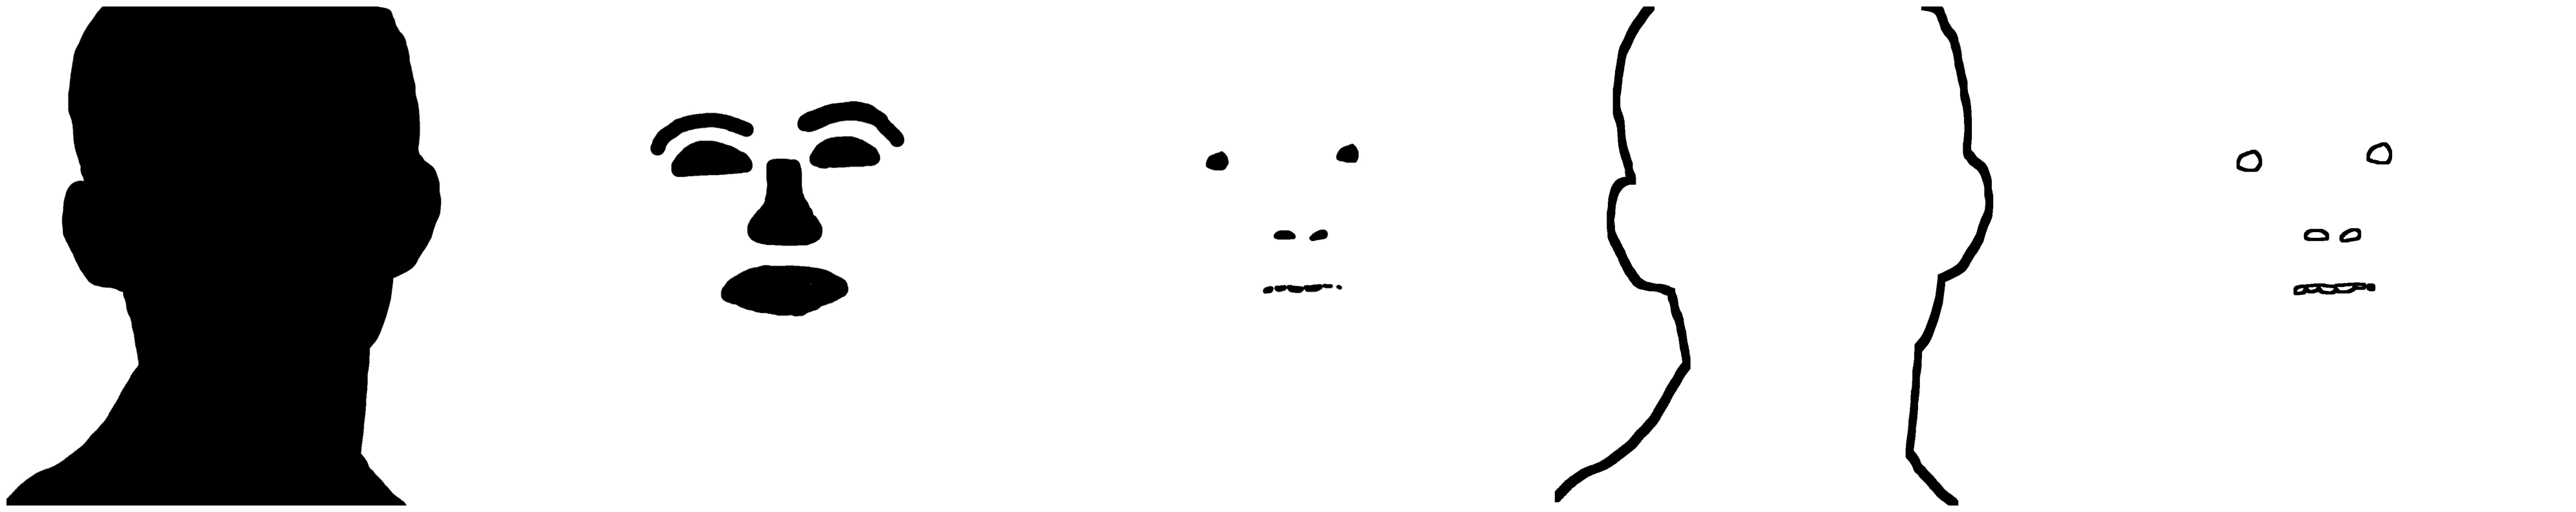

In [18]:
general = create_overlay("data/importance_maps/tom/general.jpg")
features = create_overlay("data/importance_maps/tom/features.jpg")
details = create_overlay("data/importance_maps/tom/details.jpg")
general_edges = detect_edges_color(general, low_threshold=30, high_threshold=80, gaussian_blur_size=1, dilate_iterations=10)
details_edges = detect_edges_color(details, low_threshold=30, high_threshold=80, gaussian_blur_size=1, dilate_iterations=4)
display_images([general, features, details, general_edges, details_edges])

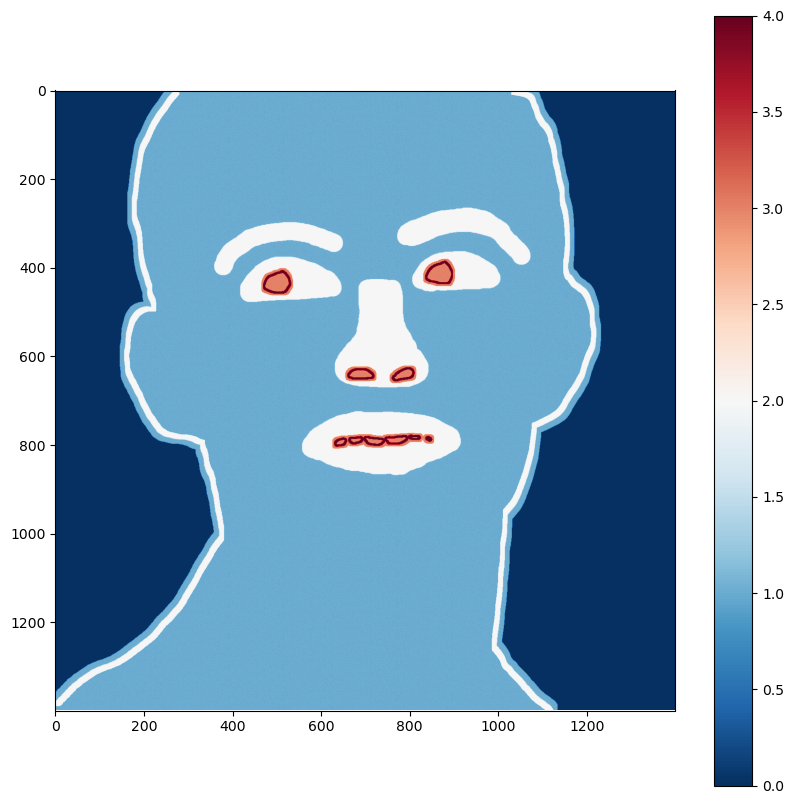

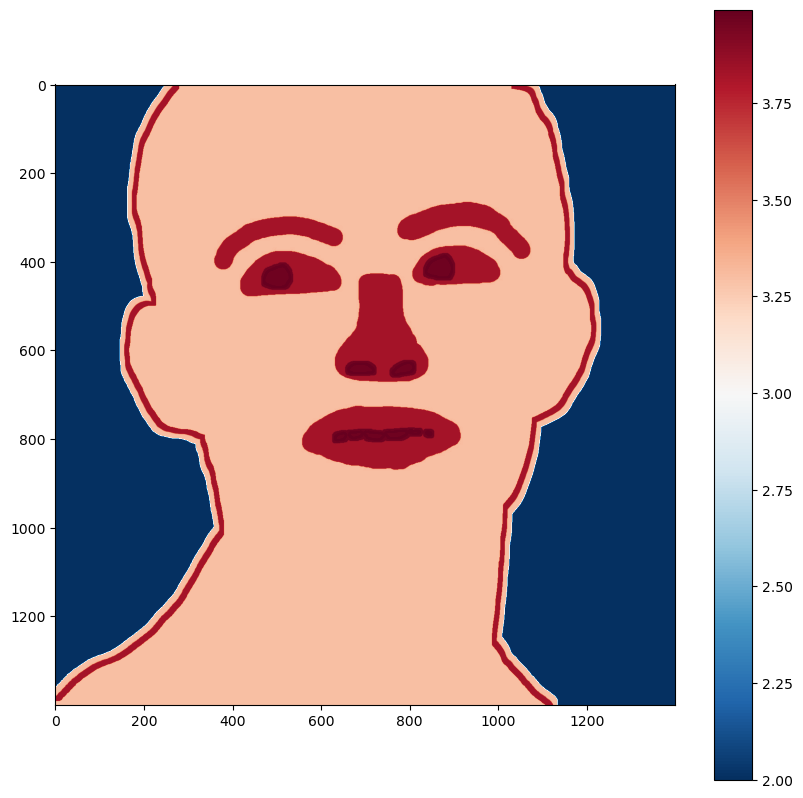

In [19]:
all_maps = general+features+details+general_edges+details_edges
display_importance(all_maps)
all_maps = dynamic_sigmoid(all_maps, C=4)
display_importance(all_maps)

In [20]:
white_importance = -0.5
white_map = white_importance_map(art.img, C=white_importance)
#display_importance(white_map)

In [21]:
art.create_anchors()
art.create_circle_mask()
#art.importance_map = all_maps

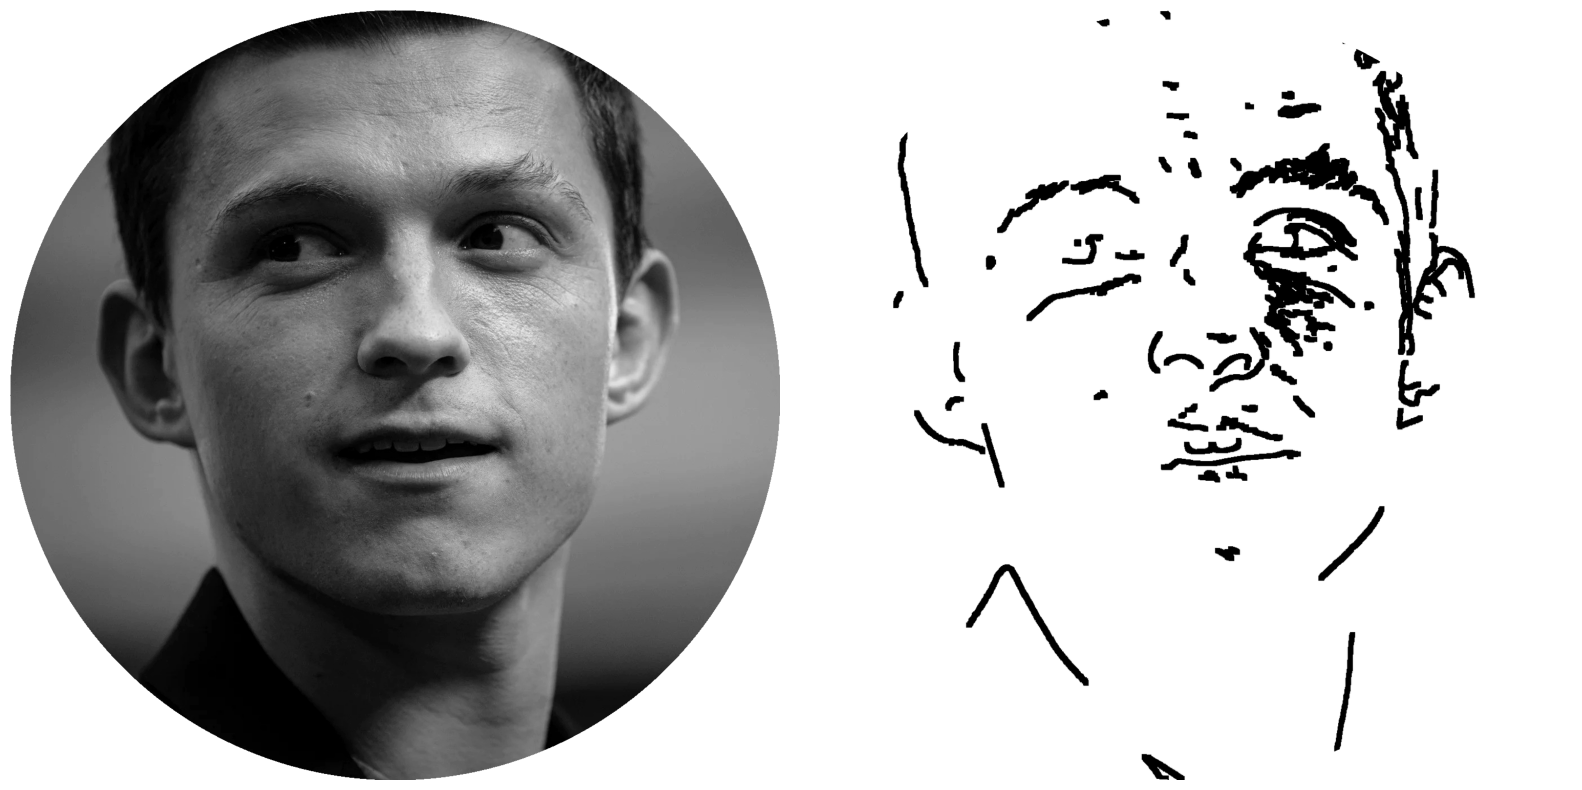

In [22]:
display_images([art.img, art.importance_map])

In [23]:
art.benchmark_line_dict()

Starting benchmark for line dict
Done! Generated 288 anchor lines on a canvas of size of 1400 in 401.4 milliseconds. Estimated time for generating line dict is about 57.6 seconds


In [24]:
art.make_line_dict()

In [25]:
print(art.line_pixel_dict.keys())

dict_keys([((1379, 866), (1399, 700)), ((1375, 881), (1399, 700)), ((1371, 896), (1399, 700)), ((1367, 910), (1399, 700)), ((1362, 925), (1399, 700)), ((1357, 939), (1399, 700)), ((1351, 953), (1399, 700)), ((1346, 967), (1399, 700)), ((1340, 982), (1399, 700)), ((1334, 995), (1399, 700)), ((1327, 1009), (1399, 700)), ((1320, 1023), (1399, 700)), ((1313, 1036), (1399, 700)), ((1305, 1050), (1399, 700)), ((1298, 1063), (1399, 700)), ((1290, 1076), (1399, 700)), ((1281, 1088), (1399, 700)), ((1273, 1101), (1399, 700)), ((1264, 1113), (1399, 700)), ((1255, 1126), (1399, 700)), ((1245, 1138), (1399, 700)), ((1235, 1149), (1399, 700)), ((1226, 1161), (1399, 700)), ((1215, 1172), (1399, 700)), ((1205, 1183), (1399, 700)), ((1194, 1194), (1399, 700)), ((1183, 1205), (1399, 700)), ((1172, 1215), (1399, 700)), ((1161, 1226), (1399, 700)), ((1149, 1235), (1399, 700)), ((1138, 1245), (1399, 700)), ((1126, 1255), (1399, 700)), ((1113, 1264), (1399, 700)), ((1101, 1273), (1399, 700)), ((1088, 1281)

In [26]:
art.create_string_art_img()
art.create_difference_img()

In [27]:
art.benchmark_string_art()

Starting benchmark for string art
Done! Found the best line out of 287 anchors lines on a canvas of size of 1400x1400 in 68.9 milliseconds. Estimated time for finding all lines is 413.6 seconds


In [28]:
art.create_string_art()

Drawing Line: 100%|██████████| 6000/6000 [05:54<00:00, 16.95it/s]


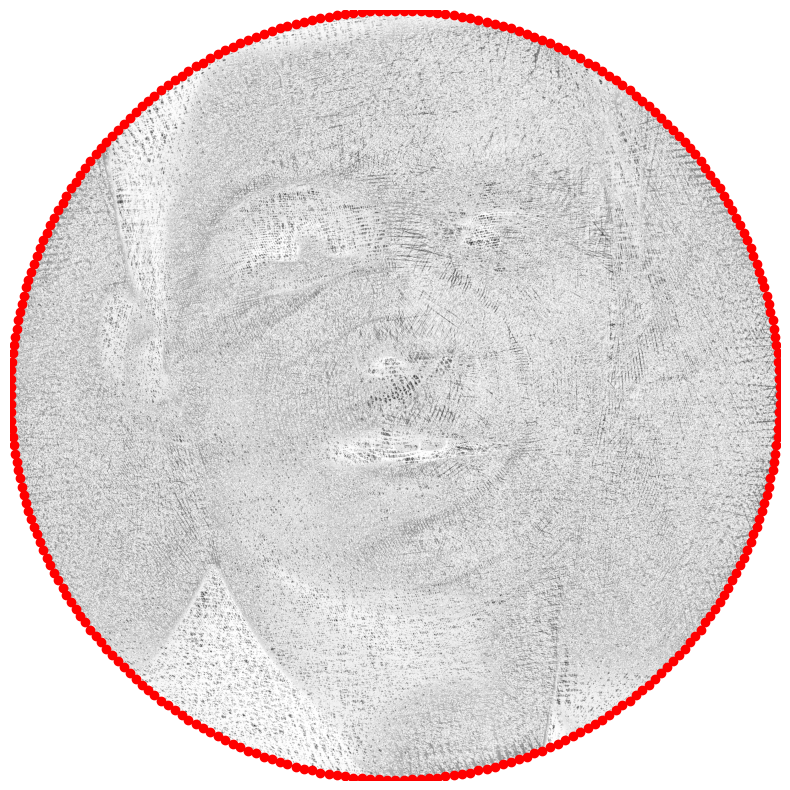

In [29]:
plt.figure(figsize=(10, 10))  
plt.imshow(art.difference_img.T, cmap='gray_r')
anchors_x, anchors_y = zip(*art.anchors)
plt.scatter(anchors_x, anchors_y, color='red')
plt.axis('off')
plt.show()  

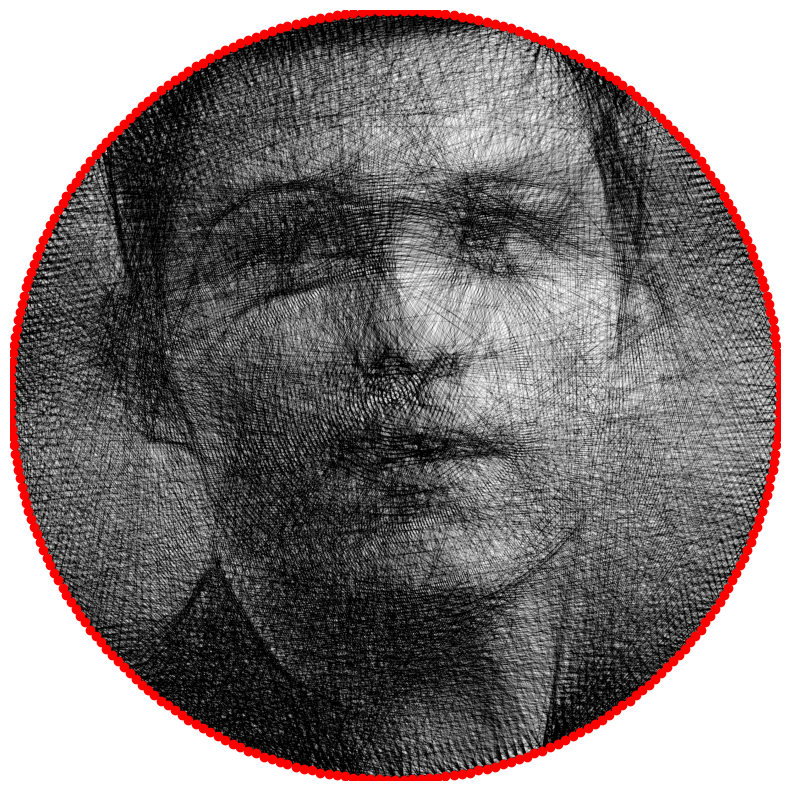

In [30]:
plt.figure(figsize=(10, 10))  
plt.imshow(art.string_art_img.T, cmap='gray_r', vmin=0, vmax=1)
anchors_x, anchors_y = zip(*art.anchors)
plt.scatter(anchors_x, anchors_y, color='red')
plt.axis('off')
plt.show()

In [31]:
save_dir = "outputs/cursortest"

In [32]:
art.save_data(save_dir)

In [33]:
create_img_from_anchors(save_dir, [10, 20, 30, 40, 50, 60, 70, 80, 90])